## Inicialización

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1./255)

#Utilizo flow_from_dataframe por la estructura del folder donde se encuentran las imágenes
train_datagen_flow = datagen.flow_from_dataframe(
    
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    seed=123
    )



Found 7591 validated image filenames.


In [3]:
features, target = next(train_datagen_flow)

In [4]:
features.shape

(16, 150, 150, 3)

In [5]:
target

array([30, 71, 39,  2, 44,  5, 38, 45, 14, 36, 60, 16, 23, 43, 46, 27])

## EDA

In [6]:
#Valores ausentes
print(labels.isna().sum())

file_name    0
real_age     0
dtype: int64


In [7]:
#Valores duplicados
print(labels.duplicated().sum())

0


In [8]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [9]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


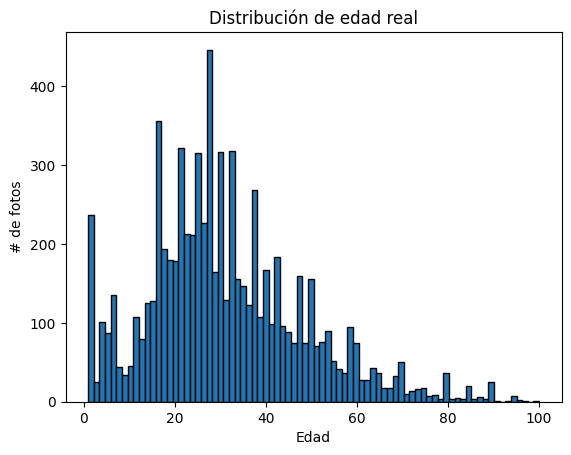

In [10]:
plt.hist(labels['real_age'], bins=80, edgecolor='black')

plt.xlabel('Edad')
plt.ylabel('# de fotos')
plt.title('Distribución de edad real')

plt.show()

In [11]:
age_count = labels['real_age'].value_counts().reset_index()
age_count.rename(columns={'index':'edad', 'real_age':'total'}, inplace=True)
age_count.head(10)

,edad,total
0,30,317
1,25,315
2,27,229
3,26,226
4,28,217
5,23,213
6,24,211
7,18,193
8,16,193
9,19,180


<AxesSubplot:>

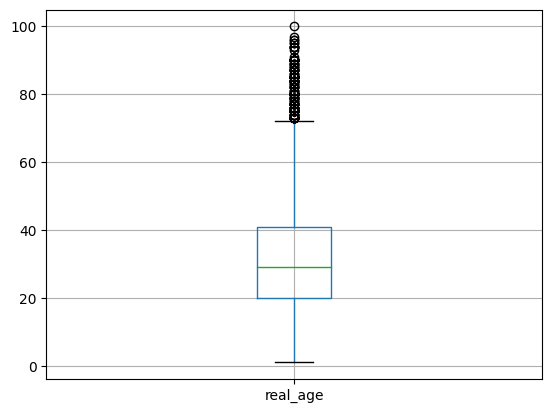

In [12]:
labels.boxplot('real_age')

In [13]:
underage = (labels['real_age']<18).sum()
total = len(labels['real_age'])

In [14]:
print("Total menores de 18 años:", underage)
print("Porcentaje de menores de 18 años:", round(underage/total*100,2),'%')

Total menores de 18 años: 1503
Porcentaje de menores de 18 años: 19.8 %


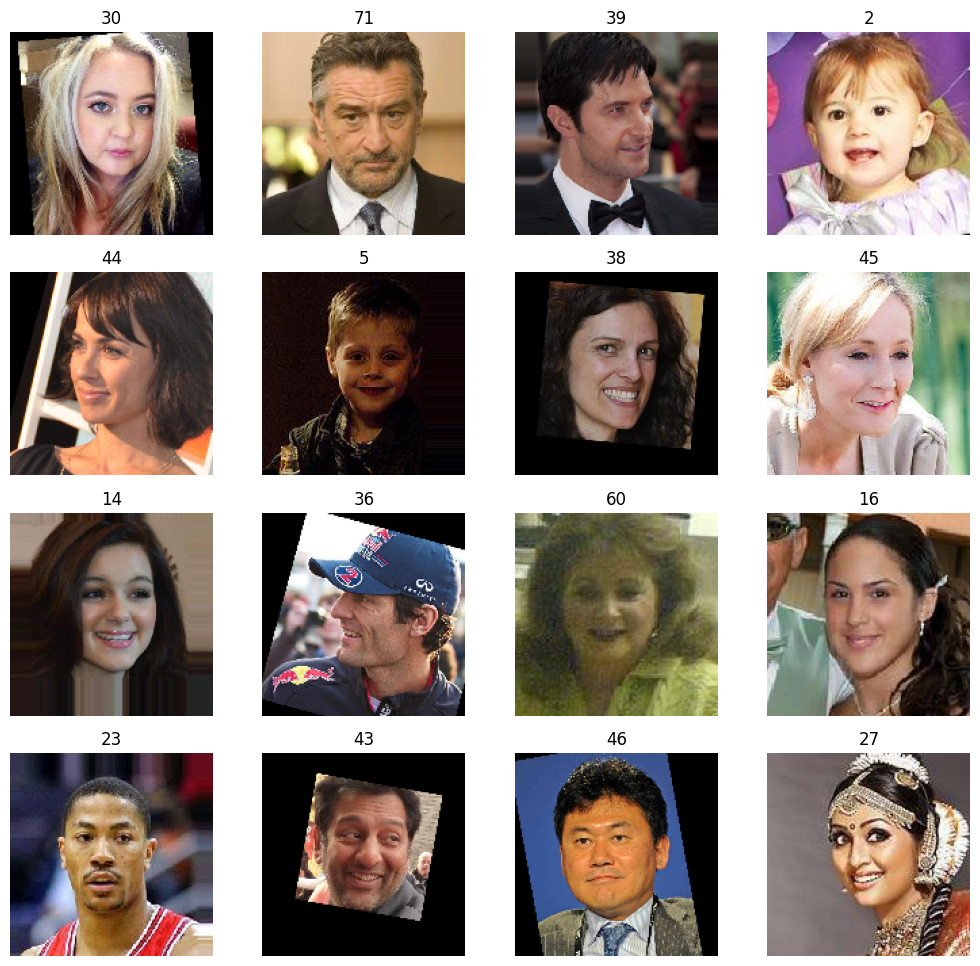

In [15]:
fig = plt.figure(figsize=(10,10), dpi=100)

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.tight_layout()
    plt.axis('off')

### Conclusiones

De acuerdo al análisis exploratorio de datos, el grupo que más visitó la tienda fue el de 30 años. 
La media de edad es de 31 años con una desviación estándar de 17.
El 19.8% de las personas es menor de 18 años.
Según el histograma la edad real está sesgada a la derecha.

Las imágenes muestran a personas en un amplio rango de edades y origen étnico. 
Algunas imágenes varían en orientación y otras fueron alargadas.

Para determinar la edad exacta se va a utilizar la técnica de regresión.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [ ]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    # coloca tu código aquí
    labels = pd.read_csv('datasets/faces/labels.csv')
    
    train_datagen = ImageDataGenerator(
        rescale=1./255, 
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.25
    )


    train_gen_flow = train_datagen.flow_from_dataframe(
    
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=1234,
        subset='training'
    )

    return train_gen_flow

In [ ]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    # coloca tu código aquí
    labels = pd.read_csv('/Volumes/Untitled/datasets/faces/labels.csv')
    
    #  coloca tu código aquí
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=1234,
        subset='validation')

    return test_gen_flow

In [ ]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    # coloca tu código aquí
    backbone= ResNet50(
        input_shape=input_shape, 
        weights='imagenet', 
        include_top=False)
    
    model = Sequential()

    optimizer = Adam(learning_rate=0.001)
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    #model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    model.compile(
        optimizer=optimizer, 
        loss='mean_squared_error', 
        metrics=['mae'])

    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    # # coloca tu código aquí
    steps_per_epoch = train_data.samples // train_data.batch_size
    validation_steps = test_data.samples // test_data.batch_size

    model.fit(
        train_data, 
        validation_data=test_data, 
        epochs=epochs, 
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True)
    

    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [ ]:

# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')
        f.write("""
if __name__ == "__main__":
    print("Loading data...")
    #1. Load Data
    train_data = load_train("/datasets/faces/final_files/")
    test_data = load_test("/datasets/faces/final_files/")

    #2. Build Model
    print("Creating model...")
    model = create_model((224, 224, 3))

    #3. Train
    print("Training model...")
    train_model(model, train_data, test_data)
""")


### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

Epoch 1/20<br>
2026-01-28 19:24:29.070533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.<br>
177/177 - 274s - 2s/step - loss: 258.2304 - mae: 12.3629 - val_loss: 443.5206 - val_mae: 15.9965<br>
Epoch 2/20<br>
177/177 - 16s - 89ms/step - loss: 217.6411 - mae: 12.0434 - val_loss: 454.6837 - val_mae: 16.2539<br>
Epoch 3/20<br>
177/177 - 265s - 1s/step - loss: 188.6868 - mae: 10.6113 - val_loss: 357.1747 - val_mae: 14.0580<br>
Epoch 4/20<br>
177/177 - 17s - 95ms/step - loss: 286.2144 - mae: 12.3574 - val_loss: 368.9690 - val_mae: 14.3075<br>
Epoch 5/20<br>
177/177 - 254s - 1s/step - loss: 172.1988 - mae: 10.0370 - val_loss: 305.9306 - val_mae: 13.0003<br>
Epoch 6/20<br>
177/177 - 17s - 94ms/step - loss: 170.0919 - mae: 10.1138 - val_loss: 304.4402 - val_mae: 12.9951<br>
Epoch 7/20<br>
177/177 - 242s - 1s/step - loss: 161.5952 - mae: 9.7408 - val_loss: 236.0013 - val_mae: 11.9141<br>
Epoch 8/20<br>
177/177 - 16s - 92ms/step - loss: 146.5751 - mae: 9.8157 - val_loss: 239.4486 - val_mae: 12.1734<br>
Epoch 9/20<br>
177/177 - 239s - 1s/step - loss: 153.0206 - mae: 9.4613 - val_loss: 255.8827 - val_mae: 11.9635<br>
Epoch 10/20<br>
177/177 - 16s - 91ms/step - loss: 105.5688 - mae: 8.3922 - val_loss: 259.6911 - val_mae: 12.0518<br>
Epoch 11/20<br>
177/177 - 236s - 1s/step - loss: 145.2420 - mae: 9.1477 - val_loss: 195.6480 - val_mae: 10.7651<br>
Epoch 12/20<br>
177/177 - 16s - 89ms/step - loss: 170.9976 - mae: 9.6217 - val_loss: 208.7662 - val_mae: 11.1098<br>
Epoch 13/20<br>
177/177 - 217s - 1s/step - loss: 136.9068 - mae: 8.9553 - val_loss: 174.7726 - val_mae: 9.7774<br>
Epoch 14/20<br>
177/177 - 16s - 88ms/step - loss: 105.7801 - mae: 7.8936 - val_loss: 156.0649 - val_mae: 9.2603<br>
Epoch 15/20<br>
177/177 - 218s - 1s/step - loss: 135.5493 - mae: 8.9009 - val_loss: 326.6222 - val_mae: 13.9018<br>
Epoch 16/20<br>
177/177 - 16s - 90ms/step - loss: 128.1829 - mae: 8.4398 - val_loss: 306.0647 - val_mae: 13.3260<br>
Epoch 17/20<br>
177/177 - 244s - 1s/step - loss: 127.2459 - mae: 8.5341 - val_loss: 174.7356 - val_mae: 10.1814<br>
Epoch 18/20<br>
177/177 - 16s - 89ms/step - loss: 119.4873 - mae: 8.1914 - val_loss: 180.2316 - val_mae: 10.2856<br>
Epoch 19/20<br>
177/177 - 1800s - 10s/step - loss: 125.1271 - mae: 8.5342 - val_loss: 151.7544 - val_mae: 9.2940<br>
Epoch 20/20<br>
177/177 - 13s - 71ms/step - loss: 109.5816 - mae: 7.4597 - val_loss: 164.8843 - val_mae: 9.6255<br>

## Conclusiones

EDA<br>
De acuerdo al análisis exploratorio de datos, el grupo que más visitó la tienda fue el de 30 años. 
La media de edad es de 31 años con una desviación estándar de 17.
El 19.8% de las personas es menor de 18 años.
Según el histograma la edad real está sesgada a la derecha.

Modelo<br>
El modelo es una red neuronal que usa arquitectura Rest50 con 20 epochs que logró un error absoluto medio de 9.62. No logra el objetivo de menos de 8.